In [1]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", url, cache_dir="extras/.", extract=True)
text = (pathlib.Path(path).with_name("spa-eng") / "spa.txt").read_text()
text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)

In [3]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

vocab_size = 1000
max_length = 50
embed_size = 128

text_vec_en = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size, output_sequence_length=max_length
)
text_vec_es = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size, output_sequence_length=max_length
)
text_vec_en.adapt(sentences_en)
text_vec_es.adapt([f" <sos> {s} <eos>" for s in sentences_es])

encoder_inputs = tf.keras.Input([], dtype=tf.string)
decoder_inputs = tf.keras.Input([], dtype=tf.string)
encoder_input_ids = text_vec_en(encoder_inputs)
decoder_input_ids = text_vec_en(decoder_inputs)

encoder_embed_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)
decoder_embed_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True)
encoder_embeddings = encoder_embed_layer(encoder_input_ids)
decoder_embeddings = decoder_embed_layer(decoder_input_ids)

In short, the left part of ``Figure`` is the encoder, and the right part is the
decoder. Each embedding layer outputs a 3D tensor of shape *[batch size,
sequence length, embedding size]*. After that, the tensors are gradually
transformed as they flow through the transformer, but their shape remains the
same.

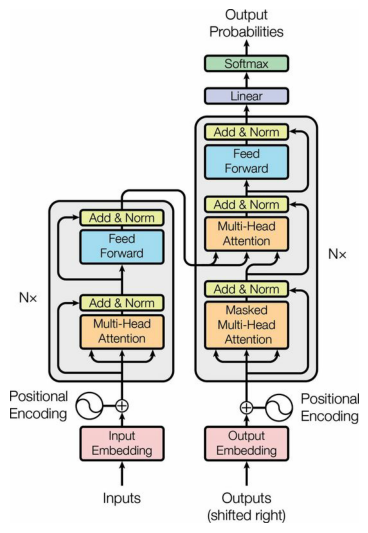

In [4]:
img = tf.io.read_file("extras/transformers.png")
img = tf.io.decode_png(img)
plt.figure(figsize=(4.5, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

That’s
where the new components come in:

* The encoder’s ***multi-head attention*** layer updates each word
representation by attending to (i.e., paying attention to) all other
words in the same sentence. That’s where the vague representation
of the word “like” becomes a richer and more accurate
representation, capturing its precise meaning in the given sentence.
We will discuss exactly how this works shortly.

* The decoder’s ***masked multi-head attention*** layer does the same
thing, but when it processes a word, it doesn’t attend to words
located after it: it’s a causal layer. For example, when it processes
the word “gusta”, it only attends to the words “<SOS> me gusta”,
and it ignores the words “el fútbol” (or else that would be
cheating).

* The decoder’s ***upper multi-head attention*** layer is where the
decoder pays attention to the words in the English sentence. This is
called cross-attention, not self-attention in this case. For example,
the decoder will probably pay close attention to the word “soccer”
when it processes the word “el” and transforms its representation
into a representation of the word “fútbol”.

* The ***positional encodings*** are dense vectors (much like word
embeddings) that represent the position of each word in the sentence. The $n^{th}$ positional encoding is added to the word
embedding of the $n^{th}$ word in each sentence. This is needed because
all layers in the transformer architecture ignore word positions:
without positional encodings, you could shuffle the input
sequences, and it would just shuffle the output sequences in the
same way. Obviously, the order of words matters, which is why we
need to give positional information to the transformer somehow:
adding positional encodings to the word representations is a good
way to achieve this.

#### **Positional encodings**

A positional encoding is a dense vector that encodes the position of a word
within a sentence: the $i^{th}$ positional encoding is added to the word embedding
of the $i^{th}$ word in the sentence. The easiest way to implement this is to use an
`Embedding` layer and make it encode all the positions *from 0 to the maximum
sequence length in the batch, then add the result to the word embeddings*. The
rules of broadcasting will ensure that the positional encodings get applied to
every input sequence. For example, here is how to add positional encodings
to the encoder and decoder inputs:

In [5]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_en = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_en))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

Alternatively, we can use fixed, non-trainable positional encodings:

In [6]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length), 2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

In [7]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

Note that this implementation assumes that the embeddings are represented
as regular tensors, not ragged tensors. The encoder and the decoder share
the same Embedding layer for the positional encodings, since they have the
same embedding size (this is often the case).

#### **Multi-head attention**

To understand how a multi-head attention layer works, we must first
understand the ***scaled dot-product attention layer***, which it is based on. Its
equation is shown in ``Equation``, in a vectorized form. It’s the same as
Luong attention, except for a scaling factor.

Attention($Q,K,V$)=softmax( $QK^{⊺}dkeysV$)

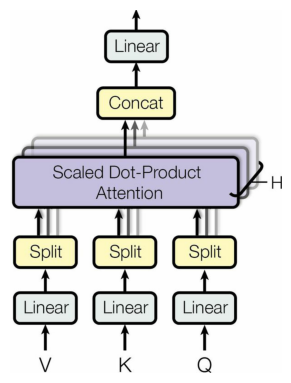

In [8]:
img = tf.io.read_file("extras/multihead_attention.png")
img = tf.io.decode_png(img)
plt.figure(figsize=(3.5, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

Keras includes a `tf.keras.layers.MultiHeadAttention` layer, so we now have
everything we need to build the rest of the transformer. Let’s start with the
**full encoder**, which is exactly like in ``Figure``, except we use a stack of
two blocks (N = 2) instead of six, since we don’t have a huge training set, and
we add a bit of dropout as well:

In [9]:
N = 2  # instead of 6
num_heads = 8
dropout_rate = 0.1
n_units = 128  # for the first Dense layer in each Feed Forward block
encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]
Z = encoder_in
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate
    )
    Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.Dropout(dropout_rate)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

This code should be mostly straightforward, except for one thing: masking.
As of the time of writing, the MultiHeadAttention layer does not support
automatic masking,⁠ so we must handle it manually.

Now on to the decoder! Once again, masking is going to be the only tricky
part, so let’s start with that. The first multi-head attention layer is a selfattention
layer, like in the encoder, but it is a masked multi-head attention
layer, meaning it is causal: it should ignore all tokens in the future. So, we
need two masks: a padding mask and a causal mask. Let’s create them:

In [10]:
decoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]
causal_mask = tf.linalg.band_part(  # creates a lower triangular matrix
    tf.ones((batch_max_len_dec, batch_max_len_dec), tf.bool), -1, 0
)

In [11]:
encoder_outputs = Z  # let's save the encoder's final outputs
Z = decoder_in  # the decoder starts with its own inputs
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate
    )
    Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate
    )
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [12]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[Y_proba])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 50)                   0         ['input_1[0][0]',             
 ctorization)                                                        'input_2[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 50, 128)              128000    ['text_vectorization[1][0]